In [ ]:
import pandas as pd
import random
import numpy as np 
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
class dataproc:
  """A simple class for ranking detectors by speed and occupancy"""
  def __init__(self,path):
    self.path = path
    self.n = 1
    self.days = [2,3]

  def read_csv_format(self):
    df = pd.read_csv(self.path)
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    return df
  
  def pick_random(self):
    # df is dataframe
    # n is the number of detectors to filter
    df = self.read_csv_format()
    unique_detectors = df['detector_id'].unique()
    select_detectors = random.sample(unique_detectors.tolist(),self.n)
    df_filter = df[df['detector_id'].isin(select_detectors)]
    return df_filter


  def visualize(self, df):
    return df['occupancy'].plot.hist(), df.plot(x='datetime',y='occupancy')

  def split_data(self,df):
    df['day'] = df['datetime'].dt.day 
    df['hour']= df['datetime'].dt.hour
    df = df[(df['hour']>=6) & (df['hour']<=20) ]
    return df[df['day']==self.days[0]],df[df['day']==self.days[1]]


In [ ]:
path = '/content/gdrive/My Drive/CVENG_8160/data/delay_bottleneck.csv'
dp = dataproc(path)

In [ ]:
df = dp.pick_random()

In [ ]:
df.head()

,detector_id,travelway,direction,loc,datetime,speed,volume,occupancy,congested,long,lat
233725,MI070E243.9D,70,East,242.5,2017-09-01 02:09:00,70.600000,2.400000,1.600000,0.0,-90.25885,38.69202
233726,MI070E243.9D,70,East,243.0,2017-09-01 02:09:00,54.000000,1.857143,1.428571,0.0,-90.25885,38.69202
233727,MI070E243.9D,70,East,242.5,2017-09-01 02:44:00,67.812500,1.770833,1.187500,0.0,-90.25885,38.69202
233728,MI070E243.9D,70,East,243.0,2017-09-01 02:44:00,58.333333,2.000000,1.333333,0.0,-90.25885,38.69202
233729,MI070E243.9D,70,East,242.5,2017-09-01 02:49:00,66.550000,1.237500,1.000000,0.0,-90.25885,38.69202


(<matplotlib.axes._subplots.AxesSubplot at 0x7fd955636cc0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd95551f0f0>)

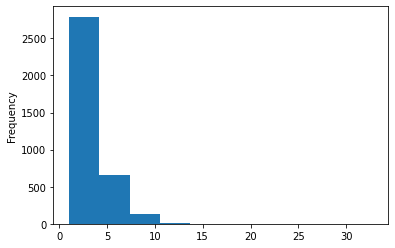

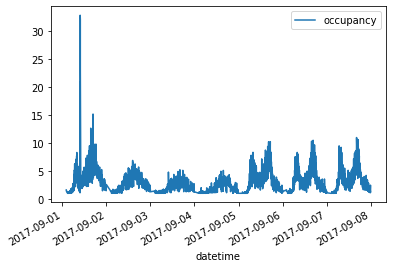

In [ ]:
dp.visualize(df)

## Stationarity

In [ ]:
[df1,df2] = dp.split_data(df)

In [ ]:
df1.head()

,detector_id,travelway,direction,loc,datetime,speed,volume,occupancy,congested,long,lat,day,hour
234320,MI070E243.9D,70,East,245.0,2017-09-02 06:09:00,62.026786,1.857143,1.133929,0.0,-90.25885,38.69202,2,6
234321,MI070E243.9D,70,East,245.5,2017-09-02 06:09:00,62.025714,1.702857,1.128571,0.0,-90.25885,38.69202,2,6
234322,MI070E243.9D,70,East,245.0,2017-09-02 06:44:00,59.850000,2.900000,1.650000,0.0,-90.25885,38.69202,2,6
234323,MI070E243.9D,70,East,245.5,2017-09-02 06:44:00,58.992500,2.780000,1.757500,0.0,-90.25885,38.69202,2,6
234324,MI070E243.9D,70,East,245.0,2017-09-02 06:49:00,58.277778,2.888889,1.888889,0.0,-90.25885,38.69202,2,6


In [ ]:
df2.head()

,detector_id,travelway,direction,loc,datetime,speed,volume,occupancy,congested,long,lat,day,hour
234830,MI070E243.9D,70,East,244.0,2017-09-03 06:09:00,58.074830,1.632653,1.170068,0.0,-90.25885,38.69202,3,6
234831,MI070E243.9D,70,East,244.5,2017-09-03 06:09:00,57.734694,1.938776,1.306122,0.0,-90.25885,38.69202,3,6
234832,MI070E243.9D,70,East,245.0,2017-09-03 06:44:00,60.000000,2.000000,1.200000,0.0,-90.25885,38.69202,3,6
234833,MI070E243.9D,70,East,245.5,2017-09-03 06:44:00,58.280000,1.780000,1.180000,0.0,-90.25885,38.69202,3,6
234834,MI070E243.9D,70,East,244.0,2017-09-03 06:49:00,59.555556,2.476190,1.682540,0.0,-90.25885,38.69202,3,6


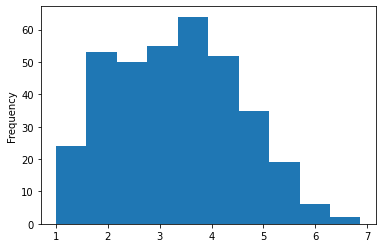

In [ ]:
df1['occupancy'].plot.hist()

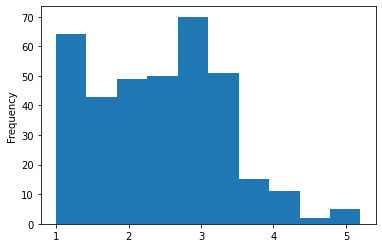

In [ ]:
df2['occupancy'].plot.hist()

In [ ]:
print ('means of both datasets')
print (df1['occupancy'].mean(),df2['occupancy'].mean())
print ('\nvariance between both datasets')
print (df1['occupancy'].var(),df2['occupancy'].var())

means of both datasets
3.3395487473669854 2.426956025992588

variance between both datasets
1.4663433237675605 0.7880906059712951


##Use Dicker fuller test to test for significance

---



In [ ]:
def cor_coeff(df1, df2,column):
  mu1,std1 = df1[column].values.mean(), df1[column].values.std()
  mu2, std2 = df2[column].values.mean(), df2[column].values.std()

  xcor,ycor = (df1[column]-mu1).values, (df2[column]-mu2).values
  if not (len(xcor) == len(ycor)):
    xcor = np.resize(xcor,ycor.shape)
  
  x_comp = np.divide(xcor,std1)
  y_comp = np.divide(ycor,std2)
  
  numerator = np.sum(np.multiply(xcor,ycor))
  denominator = np.sqrt((np.sum(xcor**2)*np.sum(ycor**2)))
  coeff = numerator/denominator

  return coeff


In [ ]:
coeff = cor_coeff(df1, df2, 'volume')
print (coeff)

0.6493156072884815


In [ ]:
# print (np.corrcoef(xcor,ycor))

In [ ]:
def cor_coeff_array(x, y):
  mu1,std1 = np.mean(x), np.std(x)
  mu2, std2 = np.mean(y), np.std(y)

  xcor,ycor = x-mu1, y-mu2
  if not (len(xcor) == len(ycor)):
    xcor = np.resize(xcor,ycor.shape)
  
  x_comp = np.divide(xcor,std1)
  y_comp = np.divide(ycor,std2)
  
  numerator = np.sum(np.multiply(xcor,ycor))
  denominator = np.sqrt((np.sum(xcor**2)*np.sum(ycor**2)))
  coeff = numerator/denominator

  return coeff

In [ ]:
# x_data = volume[0:105]
# y_data = volume[5:107]
# print (cor_coeff_array(x_data, y_data))

In [ ]:
window = 2
lag = 1
data_len = 300; # check 50 through 500
volume = df1['volume'].values; # check for occupancy and speed
corrs = []
for data_range in range(0,len(volume)-(data_len+lag),window):
  x_data = volume[0:data_range+data_len]
  y_data = volume[data_range+lag:data_range+data_len+lag]
  corrs.append(cor_coeff_array(x_data, y_data))

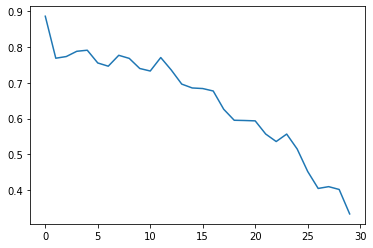

In [ ]:
plt.plot(corrs)

In [ ]:
print (cor)

0.6437052287030149


## Note! you can stationarize and non-stationary data

In [ ]:
# write a function for calculating the 5-point, moving/median average of the traffic volume column